## TradingEnv-v0

### Open AI 'Gym' for reinforcement-learning based trading algorithms

This gym implements a very simple trading environment for reinforcement learning.

The gym provides daily observations based on real market data pulled from Quandl on, by default, the SPY etf.  An episode is defined as 252 contiguous days sampled from the overall dataset.  Each day is one 'step' within the gym and for each step, the algo has a choice:

 - SHORT (0)
 - FLAT (1)
 - LONG  (2)
 
If you trade, you will be charged, by default, 10 BPS of the size of your trade.  Thus, going from short to long costs twice as much as going from short to/from flat.  Not trading also has a default cost of 1 BPS per step.  Nobody said it would be easy!
 
At the beginning of your episode, you are allocated 1 unit of cash.  This is your starting Net Asset Value (NAV). If your NAV drops to 0, your episode is over and you lose.  If your NAV hits 2.0, then you win.

At this point, I'm still figuring out what an appropriate condition for 'solved' would be in the context of OpenAI's 'Universe'... 

### Below, we look at some code using the environment


###  imports

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)


### create the environment

This may take a moment as we are pulling historical data from quandl.

In [2]:
env = gym.make('trading-v0')
#env.time_cost_bps = 0 # 


[2016-12-16 12:57:55,865] Making new env: trading-v0
[2016-12-16 12:57:55,881] gym.envs.classic_control.trading_env logger started.
[2016-12-16 12:57:55,883] getting data for GOOG/NYSE_SPY from quandl...
[2016-12-16 12:57:58,496] got data for GOOG/NYSE_SPY from quandl...


### the trading model

Each time step is a day.  Each episode is 252 trading days - a year.  Each day, we can choose to be short (0), flat (1) or long (2) the single instrument in our trading universe.

Let's run through a day and stay flat.

Annualized return:  -0.0244877755016


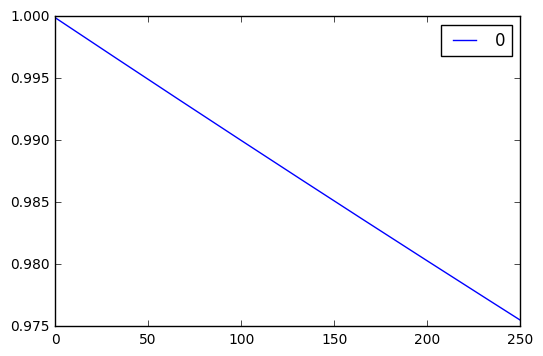

In [3]:
observation = env.reset()
done = False
navs = []
while not done:
    action = 1 # stay flat
    observation, reward, done, info = env.step(action)
    navs.append(info['nav'])
    if done:
        print 'Annualized return: ',navs[len(navs)-1]-1
        pd.DataFrame(navs).plot()


### Note that you are punished for not trading - to the tune of 1 basis point per day!


### Rendering

For now, no rendering has been implemented for this gym, but with each step, the following datum are provided which you can easily graph and otherwise visualize as we see above with the NAV:

 - pnl - how much did we make or lose between yesterday and today?
 - costs  - how much did we pay in costs today
 - nav    - our current nav
 

## DayRunnr utility class

Although the gym can be 'exercised' directly as seen above, we've also written a utility object which allows for the running of a strategy once or over many episodes, facilitating training or other sorts of analysis.

To utilize the **Dayrunnr**, strategies should be exposed as a function or lambda with the following signature:

`Action a = strategy( observation, environment )`
    
Below, we define some simple strategies and look briefly at their behavior to better understand the trading gym. 

Counter({2: 251})
   action    reward     costs       pnl       nav
0     2.0  0.000000  0.001100  0.000000  1.000000
1     2.0 -0.001100  0.000100 -0.001100  0.998900
2     2.0  0.001208  0.000100  0.001208  1.000108
3     2.0  0.007663  0.000101  0.007663  1.007771
4     2.0  0.003330  0.000101  0.003330  1.011101


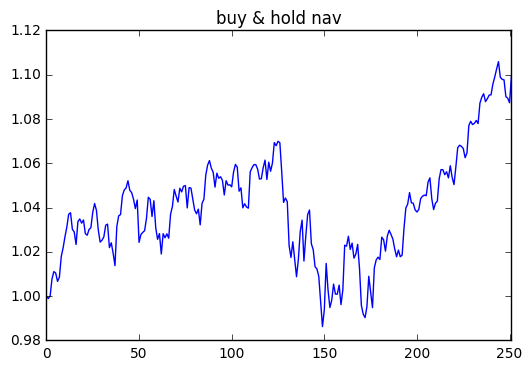

In [4]:
import trading_env as te

stayflat     = lambda o,e: 1   # stand pat
buyandhold   = lambda o,e: 2   # buy on day #1 and hold
randomtrader = lambda o,e: e.action_space.sample() # retail trader

# first we need to create the DayRunnr
runnr = te.DayRunnr(env)

# to run singly, we call run_strat.  we are returned a dataframe containing 
#  all steps in the sim and a counter enumerating the actions.
bhdf,bhac = runnr.run_strat(buyandhold)

print bhac
print bhdf.head()

# we can easily plot our nav in time:
bhdf.nav.plot(title='buy & hold nav')


### running the same strategy multiple times will likely yield different results as underlying data changes

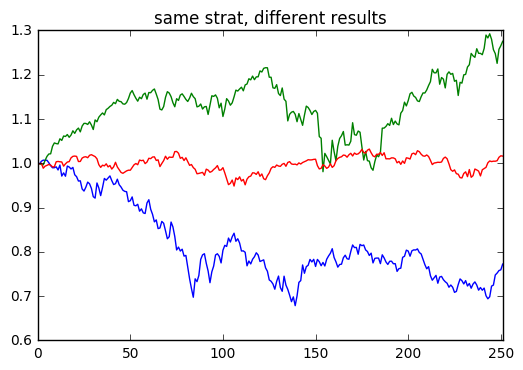

In [5]:
runnr.run_strat(buyandhold)[0].nav.plot(title='same strat, different results')
runnr.run_strat(buyandhold)[0].nav.plot()
runnr.run_strat(buyandhold)[0].nav.plot()

### using the DayRunnr to train a model or analyze batches of runs

In [6]:
# running a strategy multiple times should yield insights 
#   into its expected behavior or give it oppty to learn

bhdf,bhac = runnr.run_strats(buyandhold,100)
print 'buy and hold actions: ',bhac
print bhdf.mean()

rdf,rac = runnr.run_strats(randomtrader,100)
print 'random actions: ',rac
print rdf.mean()


buy and hold actions:  Counter({2: 25100})
ann_ret    0.031446
sharpe     0.391079
costs      0.026462
dtype: float64
random actions:  Counter({1: 8427, 0: 8379, 2: 8294})
ann_ret   -0.200173
sharpe    -1.675408
costs      0.222251
dtype: float64


Buying and holding will, over the long run, give you the market return with low costs.

Randomly trading will destroy value rather quickly as costs overwhelm.
